In [ ]:
import numpy as np
import timeit
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interact, Button, fixed
from sklearn.datasets import fetch_openml

# **Principal Component Analysis**
We will implement the *principal component analysis* (PCA) algorithm in two versions. First, we will implement the standard version for non high-dimensional data. Subsequently, we will implement the version suited for high dimensional data and compare both versions regarding their computational complexity.

### **Data Sets** <a class="anchor" id="data-sets"></a>

In this notebook, we will consider two kinds of data sets:
- a two-dimensional toy data set to illustrate eigenvectors
- and the image data set [MNIST](https://www.openml.org/d/554) containing images of hand-written digits.

Mathematically, we denote an obtained data set consisting of $N$ samples as a matrix $\mathbf{X} \in \mathbb{R}^{N \times D}$, where the $n$-th row of this matrix represents the $n$-th samples being a $D$-dimensional feature vector: $\mathbf{x}_n = (x_{n1}, \dots, x_{nD})^\mathrm{T}$.

Below, we generate the toy data set, download the image data set, and visualize both.

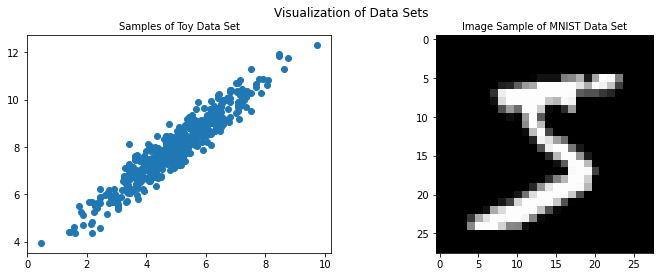

In [ ]:
# Generate toy data set.
X_toy = np.random.RandomState(42).multivariate_normal(mean=[5, 8], cov=[[2, 1.9], [1.9, 2]], size=500)

# Download MNIST data set.
X_img, y_img = fetch_openml('mnist_784', version=1, return_X_y=True)

# Plot data sets.
fig = plt.figure(figsize=(12, 4))
fig.suptitle('Visualization of Data Sets')
plt.subplot(121)
plt.title('Samples of Toy Data Set', fontsize=10)
plt.scatter(X_toy[:, 0], X_toy[:, 1])
plt.subplot(122)
plt.title('Image Sample of MNIST Data Set', fontsize=10)
plt.imshow(X_img[0].reshape(28, 28), cmap='gray')
plt.show()

### **Standardization** <a class="anchor" id="standardization"></a>

Before we implement PCA, we will need to standardize the data sets. The feature value $x_{*d}$ of a sample $\mathbf{x}_*$ can be standardized according to
t the samples will have zero mean and one varia\begin{equation}
    x_{*d} \leftarrow \frac{x_{*d} - \mu_d}{\sigma_d},
\end{equation}
where $\mu_d \in \mathbb{R}$ denotes the mean and $\sigma_d \in \mathbb{R}_{>0}$ the standard deviation of the $d$-th feature. Both are usually computed on a training data set $\mathbf{X}$.
The standardization ensures that the samples will have zero mean and one variance. It also known as
[data normalization or feature scaling](https://en.wikipedia.org/wiki/Feature_scaling).

> A corresponding class for standardization is to be implemented below.

In [ ]:
class StandardScaler:
    """Standardize features by removing the mean and scaling to unit variance."""

    def fit(self, X):
        """Determine required parameters to standardize data.

        Args:
            X (array-like): Input samples

        Returns:
            The fitted StandardScaler object.
        """
####################
# Your Code Here   #
####################

    def transform(self, X):
        """Standardizes input samples `X`.

        Args:
            X (array-like): Input samples.

        Returns:
            Standardized samples.
        """
####################
# Your Code Here   #
####################

    def inverse_transform(self, Z):
        """Scales back the data to the original data representation.

        Args:
            Z (array-like): Standardized samples.

        Returns:
            Re-scaled samples.
        """
####################
# Your Code Here   #
####################

> Standardize both data sets and visualize the results.

In [ ]:
####################
# Your Code Here   #
####################

#### **Question:**
Why should we standardize data before applying PCA?

####################
 Your Text Here   
####################

### **PCA on Toy Data Set** <a class="anchor" id="pca-on-toy-data-set"></a>

Now we will implement PCA given a training set $\mathbf{X}$ with mean $\boldsymbol{\mu} \in \mathbb{R}^D$ (being $\mathbf{0}$ if $\mathbf{X}$ has been standardized) to transform samples from the $D$-dimensional space into an $M \leq D$ dimensional space.
We then need to perform the following steps.

> A corresponding class for the PCA is to be implemented below.

   
A common way to determine the number of principal components $M$ is to define a threshold $c \in (0, 1]$ for the **explained variance** such that
\begin{equation}
M_c = \text{arg min}_{M \in \{1, \dots, D\}} M \quad \text{ s.t. } \quad \frac{\sum_{j=1}^{M} \lambda_{i_j}}{\sum_{i=l}^{D} \lambda_{l}} \geq c.
\end{equation}

> Determine the number of components based on explained variance if `n_components` is in the intervall $(0, 1]$.

In [ ]:
class PCA:
    """This class implements the principal component analysis for N >= D,
        where N is the number of samples and D is the number of features.

    Args:
        n_comonents (int, float): If `n_components` is an integer, the number of dimension will be reduced
            from D to `n_components`. If `0 < n_components < 1`,  select the number
            of components such that the amount of variance that needs to be explained
            is greater or equal than the percentage specified by `n_components`.

    """
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        """Determine required parameters of the PCA.

        Args:
            X (array-like): Input samples.

        Returns:
            The fitted PCA object.
        """
####################
# Your Code Here   #
####################

    def transform(self, X):
        """ Transforms samples from the D-dimensional input space into
            the M-dimensional projection space.

        Args:
            X (ndarray): Samples in the input space.

        Returns
            Transformed samples in the projection space.
        """
####################
# Your Code Here   #
####################

    def inverse_transform(self, Z):
        """ Retransforms samples from the M-dimensional projection space into
            the D-dimensional input space.

        Args:
            Z (array-like): Samples in the projection space.

        Returns:
            Re-transformed samples in the input space.
        """
####################
# Your Code Here   #
####################

    def _determine_M(self):
        """Determine number of finally selected components."""
####################
# Your Code Here   #
####################

> Having implemented the PCA, we apply it to the two-dimensional toy data set to visualize eigenvectors and eigenvalues.

In [ ]:
####################
# Your Code Here   #
####################

### **PCA on Image Data Set** <a class="anchor" id="pca-on-image-data-set"></a>

In this section, we will analyze the performance of the PCA on the image data set MNIST. Therefor, we analyze how the number of selected principal components $M$ affects our reconstruction error be.
> Implement a function for computing the reconstruction error (i.e., mean squared error):
\begin{equation}
J = \frac{1}{N} \sum_{n=1}^{N} ||\mathbf{x}_n - \tilde{\mathbf{x}}_{n}||^2.
\end{equation}

In [ ]:
def compute_reconstruction_error(X_orig, X_rec):
    """Computes the reconstruction error, i.e., mean squared error.

    Args:
        X_orig (array-like): Original samples.
        X_rec (array-like): Reconstructed samples.

    Returns:
        Reconstruction error.
    """
####################
# Your Code Here   #
####################

> Compute the error in dependence of the number of selected components $M$.

In [ ]:
####################
# Your Code Here   #
####################

> Finally, show the qualitative performance of the PCA through visual inspections of examples for different values of the explained variance.

In [ ]:
####################
# Your Code Here   #
####################